In [1]:
from dotenv import dotenv_values
import httpx
from datetime import datetime
from dateutil.relativedelta import relativedelta
import json
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
global rolling_window 

In [3]:
def pretty_plot(df: pd.DataFrame, token_name: str):
    df.plot(x='timestamp', y='prices', kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Prices in USD')
    plt.title(label=f'Prices of {token_name} in USD')
    plt.show()

In [4]:
def pretty_plot_with_sma(df: pd.DataFrame, token_name: str):
    # Plot the dataframe with the SMA
    df.plot(x='timestamp', y=['prices', 'SMA'], kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Prices')
    plt.title(label=f'SMA of {token_name} in USD')
    plt.legend(['Prices', 'SMA'])
    plt.show()

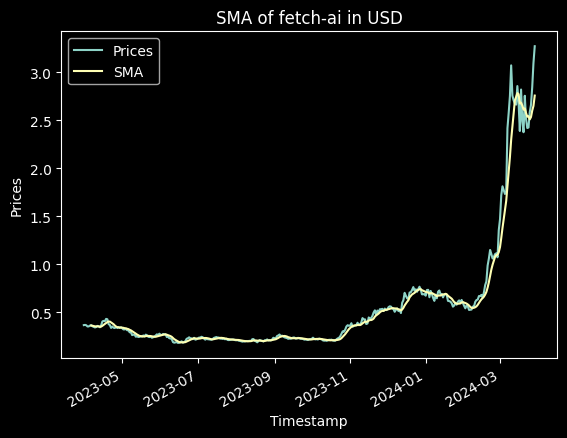

   timestamp    prices   market_caps  total_volumes  SMA
0 2023-03-31  0.365936  3.821533e+08   6.630799e+07  NaN
1 2023-04-01  0.368197  3.844138e+08   4.971702e+07  NaN
2 2023-04-02  0.364197  3.800977e+08   3.680425e+07  NaN
3 2023-04-03  0.351340  3.662266e+08   3.648945e+07  NaN
4 2023-04-04  0.352661  3.691995e+08   5.901369e+07  NaN


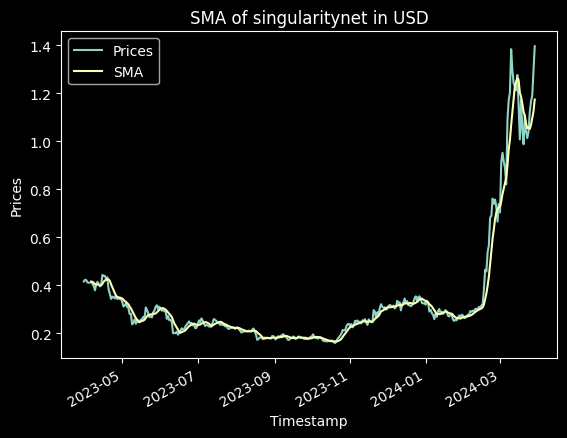

   timestamp    prices   market_caps  total_volumes  SMA
0 2023-03-31  0.415697  5.017489e+08   1.171957e+08  NaN
1 2023-04-01  0.423068  5.109914e+08   9.079633e+07  NaN
2 2023-04-02  0.420957  5.074527e+08   1.003063e+08  NaN
3 2023-04-03  0.411355  4.957792e+08   5.076404e+07  NaN
4 2023-04-04  0.410533  4.964463e+08   7.983657e+07  NaN


In [5]:

def write_json_to_file(data: dict):
    with open("tmp.json", "w") as f:
        json.dump(obj=data, fp=f, indent=4)


def get_unix_timestamps(delta_in_months: int = 1):
    now = datetime.now()
    requested_time = now - relativedelta(months=delta_in_months)

    now_unix = int(now.timestamp())
    requested_time_unix = int(requested_time.timestamp())

    return now_unix, requested_time_unix


def clean_data(data: dict, rolling_window: int = 30):
    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Process each category in the JSON data
    for key in data.keys():
        # Convert the data into a temporary DataFrame
        temp_df = pd.DataFrame(data[key], columns=['timestamp', key])
        
        # If our main DataFrame is empty, start it with this category's DataFrame
        if df.empty:
            df = temp_df
        else:
            df = pd.merge(left=df, right=temp_df, on='timestamp', how='outer')
    df['timestamp'] = pd.to_datetime(arg=df['timestamp'], unit='ms')
    df['SMA'] = df['prices'].rolling(window=rolling_window).mean()
    
    return df


def main(token: str):
    api = dotenv_values(dotenv_path=".env")["API_KEY"]
    params = {
        'vs_currency': 'usd',
        'days': '365',
        'interval': 'daily',
        'precision': 'full',
        'x_cg_demo_api_key': api,
    }
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart"
    session = httpx.Client()
    response = session.get(url=url, params=params)
    data = clean_data(data=response.json(), rolling_window=7)
    pretty_plot_with_sma(df=data, token_name = token)
    return data
    

if __name__ == "__main__":
    df_fetch = main(token="fetch-ai")
    df_agix = main(token="singularitynet")

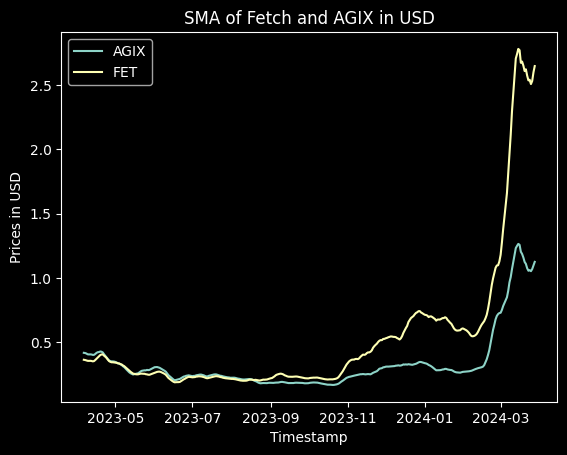

In [6]:
df_merged = pd.merge(left=df_agix, right=df_fetch, on='timestamp', suffixes=('_agix', '_fetch'))
plt.plot(df_merged['timestamp'], df_merged['SMA_agix'], label='AGIX')
plt.plot(df_merged['timestamp'], df_merged['SMA_fetch'], label='FET')
plt.xlabel(xlabel='Timestamp')
plt.ylabel(ylabel='Prices in USD')
plt.title(label="SMA of Fetch and AGIX in USD")
plt.legend()
plt.show()


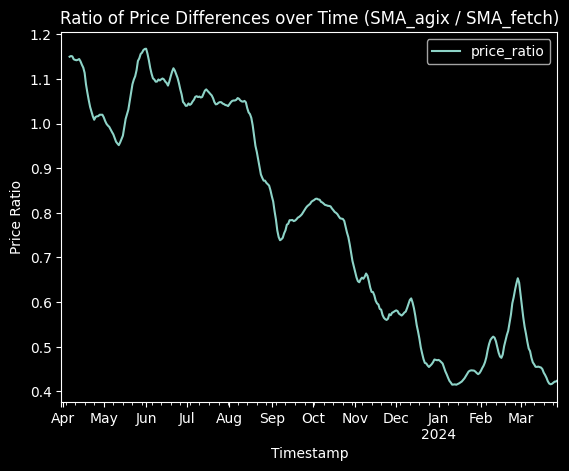

In [10]:
df_merged['price_ratio'] = df_merged['SMA_agix']/ df_merged['SMA_fetch']  
df_merged.plot(x='timestamp', y='price_ratio', kind='line')
plt.xlabel(xlabel='Timestamp')
plt.ylabel(ylabel='Price Ratio')
plt.title(label='Ratio of Price Differences over Time (SMA_agix / SMA_fetch)')
plt.show()